# Model

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,recall_score, make_scorer

from sklearn.feature_selection import RFECV

from catboost import CatBoostClassifier

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

from sklearn.ensemble import StackingClassifier

DEBUG = False
SEED = 666

## Load Data

### Data for predictions

In [2]:
df_churn_test = pd.read_pickle("./orig/data/churn_test.pkl")
print(df_churn_test.shape)
df_churn_test.head(1)

(3542, 20)


,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,Card,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Age,Education,Marital_Status,Dependents,Income,Total_Transactions,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,
708182832,1,1,1,0,0,0,0,1,1,3375.0,1730,1645.0,37,5,Single,2,2,4341.01,64,824


### Training data

In [3]:
df = pd.read_pickle("./orig/data/churn_train.pkl")
print(df.shape)
df.head(1)

(5831, 21)


,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,Churn,Card,Customer_Service_Calls,...,Total_Revolving_Balance,Average_Open_To_Buy,Age,Education,Marital_Status,Dependents,Income,Total_Transactions,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
708115009,0,0,0,0,0,0,0,Yes,1,3,...,0,5398.0,47.0,1,Single,3,1,1886.99,36,1159


In [4]:
df.dtypes

Current                       int64
Deposit                       int64
Investment                    int64
Joint                         int64
Loan                          int64
Mortgage                      int64
On Demand Deposit             int64
Churn                      category
Card                          int64
Customer_Service_Calls        int64
Credit_Limit                float64
Total_Revolving_Balance       int64
Average_Open_To_Buy         float64
Age                         float64
Education                     int64
Marital_Status             category
Dependents                    int64
Income                        int64
Total_Transactions          float64
Num_Transactions              int64
Loyalty                       int64
dtype: object

#### Features and Target

In [5]:
target = "Churn"
cat_features = [c for c in df.select_dtypes("category").columns if c not in target]
num_features = [c for c in df.select_dtypes(["int","float"]).columns if c not in target]
features = cat_features + num_features


print(f"Target: {target}")

print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")

Target: Churn
Categorical Features: ['Marital_Status']
Numerical Features: ['Current', 'Deposit', 'Investment', 'Joint', 'Loan', 'Mortgage', 'On Demand Deposit', 'Card', 'Customer_Service_Calls', 'Credit_Limit', 'Total_Revolving_Balance', 'Average_Open_To_Buy', 'Age', 'Education', 'Dependents', 'Income', 'Total_Transactions', 'Num_Transactions', 'Loyalty']


## Check Target Values

In [6]:
df[target].value_counts()

No     4919
Yes     912
Name: Churn, dtype: int64

In [7]:
df.isna().sum().sum()

0

### Comments
- From the relative frequencies above we can see clearly that the dataset is unbalanced.
- We will attempt to use a Synthetic Minority Oversampling Technique (SMOTE) to balance out the dataset later on.

## Encode Categorical Values

### Train-Test Split

In [8]:
df_train, df_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.6, stratify=df[target], random_state=SEED)
df_train.shape, df_test.shape

((3498, 20), (2333, 20))

## Encoding Values

In [9]:
def encode_df(df_train, y_train):
    cat_e = OneHotEncoder()
    num_e = StandardScaler()
    
    data = cat_e.fit_transform(df_train[cat_features]).toarray()
    index = df_train.index
    columns = cat_e.get_feature_names_out()
    df_cat = pd.DataFrame(data=data, index=index, columns=columns)

    data = num_e.fit_transform(df_train[num_features])
    index = df_train.index
    columns = num_features
    df_num = pd.DataFrame(data=data, index=index, columns=num_features)
    df_num = df_train[num_features]
    
    df_train = pd.concat([df_cat, df_num], axis=1)
    
    y_train = y_train.map( {'No':0, "Yes":1} )
    
    return df_train, y_train

### Encode churn pred dataframe

In [10]:
df_churn_test["Churn"] = "No"
df_churn_test , y_churn = encode_df(df_churn_test.iloc[:, :-1],df_churn_test["Churn"])
df_churn_test.head(1)
#np.unique(df_churn_test.Marital_Status_Unknown)

,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Current,Deposit,Investment,Joint,Loan,Mortgage,...,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Age,Education,Dependents,Income,Total_Transactions,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
708182832,0.0,0.0,1.0,0.0,1,1,1,0,0,0,...,3375.0,1730,1645.0,37,5,2,2,4341.01,64,824


### Encode Train

In [11]:
df_train, y_train = encode_df(df_train,y_train)
df_train.insert(loc=16, column='Marital_Status_Unknown',value=0)
display(df_train.head(1))

,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,...,Total_Revolving_Balance,Average_Open_To_Buy,Age,Marital_Status_Unknown,Education,Dependents,Income,Total_Transactions,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
793319878,0.0,1.0,0.0,1,1,0,0,0,0,0,...,944,621.0,51.0,0,5,3,2,4798.03,73,1190


#### Comment:
- OHE still doesnt add columns for categorical values that dont show up in a dataframe so we have to manually add in a marital status column to match the testing dataframe for churn

### Encode Test

In [12]:
df_test, y_test = encode_df(df_test, y_test)
df_test.insert(loc=16, column='Marital_Status_Unknown',value=0)
display(df_test.head(1))

,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit,...,Total_Revolving_Balance,Average_Open_To_Buy,Age,Marital_Status_Unknown,Education,Dependents,Income,Total_Transactions,Num_Transactions,Loyalty
Customer,,,,,,,,,,,,,,,,,,,,,
767479181,0.0,1.0,0.0,1,1,1,0,0,0,0,...,1335,12138.0,47.0,0,3,3,0,1593.04,46,1404


### Feature Selection

In [13]:
models = {
    "LR": LogisticRegression(max_iter=1000),
    "DT": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(),
    "ET": ExtraTreesClassifier(),
    #"XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED),
    "CB": CatBoostClassifier(silent=True),
    "CB_HPT": CatBoostClassifier(depth=7,iterations=50, learning_rate=0.1,silent=True),
    "ADA": AdaBoostClassifier(n_estimators=100,random_state=SEED),
    "GBRT": GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)

    
}

scorer = make_scorer(recall_score)

Optimal number of features : 18


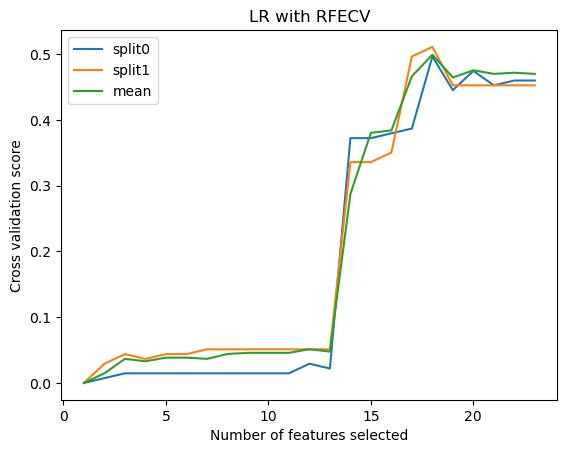

In [14]:
name = 'LR'  # use any LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(4), scoring=scorer)
rfecv.fit(df_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [15]:
if len(rfecv.support_)<len(df_train.columns):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(df_train.columns)[rfecv.support_].tolist()
features_selected

['Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Current',
 'Deposit',
 'Investment',
 'Joint',
 'Loan',
 'Mortgage',
 'On Demand Deposit',
 'Card',
 'Customer_Service_Calls',
 'Total_Revolving_Balance',
 'Age',
 'Education',
 'Dependents',
 'Income',
 'Num_Transactions']

### SMOTE

#### Define Pipeline

In [16]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.4)
#steps = [('o', over),('u',under)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

#### Applying Smote to balance datasest

In [17]:
X_smote, y_smote = pipeline.fit_resample(df_train,y_train)
#X_smote, y_smote = pipeline.fit_resample(df_train[features_selected],y_train)

/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


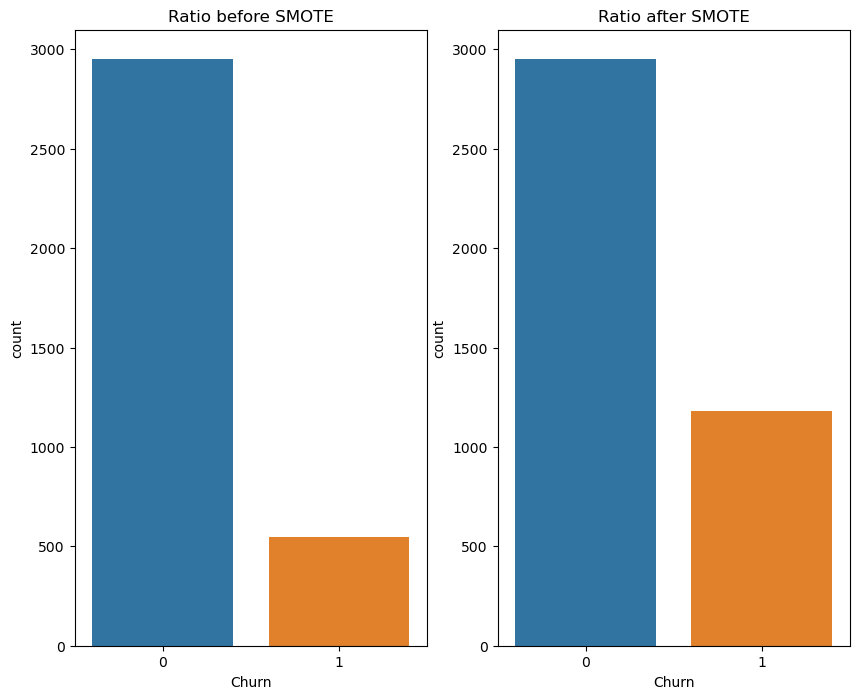

Counter({0: 2951, 1: 1180})

In [18]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Ratio before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Ratio after SMOTE')
plt.show()
Counter(y_smote)

### Model Selection

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for name,model in models.items():
    scores = cross_val_score(model, df_train, y_train, cv=cv, scoring=scorer)
    #scores = cross_val_score(model, df_train[features_selected], y_train, cv=cv, scoring=scorer)
    #scores = cross_val_score(model, X_smote, y_smote, cv=cv, scoring=scorer)
    print(name, "Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LR Recall: 0.46 (+/- 0.14)
DT Recall: 0.72 (+/- 0.16)
KNN Recall: 0.51 (+/- 0.11)
RF Recall: 0.65 (+/- 0.14)
ET Recall: 0.52 (+/- 0.14)


In [ ]:
model = CatBoostClassifier(silent=True)
model.fit(df_train, y_train)
#model.fit(df_train[features_selected], y_train)
#model.fit(X_smote, y_smote)
y_pred = model.predict(df_test)
y_pred

In [ ]:
np.unique(y_pred)

In [ ]:
def showDiagnostics(y_test, y_pred):
  # Model Accuracy, how often is the classifier correct?
  print("Accuracy:",accuracy_score(y_test, y_pred))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))
  print("Classification Report:")
  print(classification_report(y_test, y_pred, digits=3))

### CatBoost

In [ ]:
showDiagnostics(y_test,y_pred)

### Stacked Learner

In [ ]:
# level_0_models =  {
#     "DT": DecisionTreeClassifier(),
#     "RF": RandomForestClassifier(),
#     "ADA": AdaBoostClassifier(n_estimators=100,random_state=SEED),
#     "ET": ExtraTreesClassifier(),
#     "KNN": KNeighborsClassifier()
# }

level_0_models = models

level_1_model = models['CB']

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

stacking_model = StackingClassifier(
    estimators=list(level_0_models.items()), final_estimator=level_1_model, 
    passthrough=True, cv=cv, stack_method="predict_proba")

In [ ]:
#stacking_model.fit(df_train, y_train)
#tmp = stacking_model.fit_transform(X_smote, y_smote)
tmp = stacking_model.fit_transform(df_train, y_train)

In [ ]:
level_0_columns = [f"{name}_prediction" for name in level_0_models.keys()]
level_0_columns
df_stacked = pd.DataFrame(tmp, columns=level_0_columns+list(X_smote.columns))
df_stacked.head()

In [ ]:
y_pred_stacking = stacking_model.predict(df_test)

showDiagnostics(y_test, y_pred_stacking)

## Ensemble Learning

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=1)

CatBoost_CLF = CatBoostClassifier(silent=True)

CatBoost_CLF.fit(df_train,y_train)
#CatBoost_CLF.fit(X_smote, y_smote)

In [ ]:
CatBoost_CLF.score(df_train, y_train)
#CatBoost_CLF.score(X_smote, y_smote)

In [ ]:
y_pred_ensemble = CatBoost_CLF.predict(df_test)

In [ ]:
showDiagnostics(y_test, y_pred_ensemble)

### CatBoost Hyper-parameter Tuning

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'iterations': [5, 20, 50, 100],
    'learning_rate': [0.01, 0.1, 1],
    'depth': [3, 5, 7,10,12]
}

catboost = CatBoostClassifier(silent=True)

grid_search = GridSearchCV(catboost, params, cv=5, verbose=0)


grid_search.fit(df_train, y_train)
#grid_search.fit(X_smote, y_smote)

print(grid_search.best_params_)

In [ ]:
CatBoost_HPT = CatBoostClassifier(depth=3,iterations=100, learning_rate=0.1,silent=True)

In [ ]:
CatBoost_HPT.fit(df_train,y_train)
#CatBoost_HPT.fit(X_smote,y_smote)

In [ ]:
y_pred_hpt = CatBoost_HPT.predict(df_test)
showDiagnostics(y_test,y_pred_hpt)

## Generate predictions

In [ ]:
#y_pred = model.predict(df_churn_test)
y_pred = stacking_model.predict(df_churn_test)



In [ ]:
df_pred = pd.DataFrame({'Churn': y_pred}, index=df_churn_test.index)
df_pred = df_pred.Churn.map( {0:'No', 1:"Yes"} )
df_pred = df_pred.reset_index()
print(df_pred.shape)
print(df_pred.head(5))
df_pred.to_csv("./orig/output/pred.csv",index=False)


## Kaggle Scores
- No Feature Engineering - 0.950 - CLF
- Basic Feature Engineering and SMOTE 0.944 -CLF
- SMOTE and Feature Selection - 0.942 CLF
- Feature Engineering Cat to Num, Smote - 0.938 - CLF
- Feature Engineering Cat to Num - 0.952 -CLF
- Featire Engineering Cat to Num, Stacked Learner - 0.93 - CLF
- Cat Boost hyper parameter - 0.94 -CLF
- Feature Engineering and HPT - 0.933
- Feature Engineering and ensmble - 0.939
- Feature Engineering and stacked -  0.934
- Feature Engineering and feature selection - 0.904

## Conclusion
- The best score was achieved with simple feature engineering and converting categorical values to numerical. 
- Different combintations of over and undersampling using SMOTE and RUS were evaluated, generally speaking the classification report indicated worse performance with smote. When oversampling was used by itself it gave better results in the classification report however this still ultimetely lead to lower scores on kaggle.
- Stacked and Ensmble were both used to try an optimize the model, classification reports didnt differ much when they were used and never improved the kaggle scores.
- Using the values from Hyper Parameter Tuning for CatBoostClassifier showed lower recall values than that off the basic CatBoost, I then decided not to use HyperParameter for the rest of my experimentations.
- Feature Engineering with Cat to Num conversions during the EDA improved our baseline model  and gave us our highest score.
- Feature Selection performed just as well as feature engineering with our baseline model however the results in kaggle were worse.
- The best results were achieved with a basic model and more advanced feature engineering.

I believe a better score could be achieved with a better application of feature engineering and more advnaced approach to stacked and ensemble learners. The results so far were good and spending more time fine tuning the model may not neccesarily result in significant imrovements at this point.